In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from joblib import Parallel, delayed
import gc


In [2]:
class ProductRegressor:
    def __init__(self, n_jobs=-1):
        self.models = {}
        self.n_jobs = n_jobs
    
    def fit_product(self, produto, dataset):
        scaler = StandardScaler()
        subdataset = dataset[dataset["family"] == produto]
        x = subdataset.drop(columns=['family', 'sales'])
        y = subdataset['sales']
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        regressor = RandomForestRegressor(n_estimators= 100)
        regressor.fit(x,y)
        return produto, regressor, scaler
    
    def fit(self, dataset):
        produtos = dataset["family"].unique()
        results = Parallel(n_jobs=self.n_jobs, prefer="threads")(delayed(self.fit_product)(produto, dataset) for produto in produtos)
        for produto, regressor, scaler in results:
            self.models[produto] = {'regressor': regressor, 'scaler': scaler}
        gc.collect()
    
    def predict_product(self, produto, subdataset):
        X = subdataset.drop(columns=['family', 'id'])
        model_local = self.models[produto]
        regressor = model_local['regressor']
        scaler = model_local['scaler']
        
        X = scaler.transform(X)
        predictions = regressor.predict(X)


        result_df = subdataset[['id']].copy()
        result_df['prediction'] = predictions
        return result_df
    
    def predict(self, dataset):
        dataset = dataset.copy()
        if 'id' not in dataset.columns:
            dataset['id'] = range(len(dataset))
        predictions = Parallel(n_jobs=self.n_jobs, prefer="threads")(
            delayed(self.predict_product)(produto, dataset[dataset['family'] == produto])
            for produto in dataset['family'].unique()
        )
        predictions_df = pd.concat(predictions).sort_values('id')
        gc.collect()

        return predictions_df['prediction'].values

In [3]:
def map_to_macrocategory(category):
    if category in ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                    'GROCERY I', 'GROCERY II', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']:
        return 'Alimentos e Bebidas'
    elif category in ['BABY CARE', 'BEAUTY', 'PERSONAL CARE']:
        return 'Cuidados Pessoais e Saúde'
    elif category in ['CLEANING', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 
                      'HOME CARE', 'LAWN AND GARDEN']:
        return 'Casa e Jardim'
    elif category in ['LADIESWEAR', 'LINGERIE']:
        return 'Moda e Vestuário'
    elif category == 'AUTOMOTIVE':
        return 'Automotivo'
    elif category == 'PET SUPPLIES':
        return 'Animais de Estimação'
    elif category in ['BOOKS', 'MAGAZINES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'HARDWARE']:
        return 'Lazer, Tecnologia e Ferramentas'
    elif category == 'LIQUOR,WINE,BEER':
        return 'Bebidas Alcoólicas'
    elif category == 'SCHOOL AND OFFICE SUPPLIES':
        return 'Escola e Escritório'
    else:
        return 'Outros'

In [4]:
def adding_date(data):
    data['date']= pd.to_datetime(data['date'])
    data.set_index('date', inplace = True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    return data


In [5]:
def payday(date):
    if date.day == 15:
        return 1
    elif date == pd.Timestamp(date.year, date.month, 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1):
        return 1
    else:
        return 0

In [6]:
def primeiro_dia_com_vendas(store_id, sales_data):
    store_sales = sales_data[sales_data['store_nbr'] == store_id]
    store_sales = store_sales.sort_values(by='date')
    if store_sales.iloc[0]['sales'] == 0:
        for idx, row in store_sales.iterrows():
            if row['sales'] > 0:
                return pd.Timestamp(row['date'])
        return None
    else:
        return pd.Timestamp(store_sales.iloc[0]['date'])

In [7]:
def feriados(dados, holidays, stores):
    # Adicionando coluna 'holiday' com 0 inicialmente
    dados['holiday'] = 0
    holidays['transferred'] = holidays['transferred'].astype(bool)
    holidays['date']= pd.to_datetime(holidays['date'])
    # Merge de 'dados' com 'stores' para trazer 'city' e 'state'
    dados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

    # Selecionando apenas colunas relevantes de 'holidays' para o merge
    holidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]

    # Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes
    dados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))
    dados['transferred'] = dados['transferred'].fillna(False)
    # Condições para definir 'holiday' com base em 'locale'
    dados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1
    dados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1
    dados.loc[(dados['locale'] == 'Local') & (dados['locale_name'] == dados['city']) & ~dados['transferred'], 'holiday'] = 1

    # Limpar colunas desnecessárias se necessário
    dados.drop(columns=['city', 'state', 'locale', 'locale_name', 'transferred'], errors='ignore', inplace=True)
    return dados

In [8]:
def RMSLE(y_pred, y_real):
    y_real = np.where(y_real <= 0, np.finfo(float).eps, y_real)
    y_pred = np.where(y_pred <= 0, np.finfo(float).eps, y_pred)
    log_real = np.log1p(y_real)
    log_pred = np.log1p(y_pred)
    mse_log = mean_squared_error(log_real, log_pred)
    rmsle_value = np.sqrt(mse_log)
    return rmsle_value

In [9]:
treino = pd.read_csv('Data/train.csv.gz', compression='gzip')
treino= treino.drop(columns=['id'])
treino['date']= pd.to_datetime(treino['date'])
stores = pd.read_csv('Data/stores.csv')
oil = pd.read_csv('Data/oil.csv')
holidays = pd.read_csv('Data/holidays_events.csv')
transactions = pd.read_csv('Data/transactions.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
val = pd.read_csv('Data/test.csv')
val['date']= pd.to_datetime(val['date'])

In [10]:
null_counts = oil.isnull().sum()
print(null_counts)

date           0
dcoilwtico    43
dtype: int64


In [11]:
oil["date"] = pd.to_datetime(oil.date)
oil = oil.set_index("date").resample("D").sum().reset_index()
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate()
oil.iloc[0] = oil.iloc[0].fillna(95)

In [12]:
#junta os dados com o óleo
dados= pd.merge(treino, oil, on=['date'], how= 'left')
dados_val = pd.merge(val, oil, on=['date'], how= 'left')

In [13]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 137.4+ MB


In [14]:
#Verifica quantos valores únicoas existem na coluna family
dados["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [15]:
#Verifica os valores nulos
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64


In [16]:
null_counts = dados_val.isnull().sum()
print(null_counts)

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dcoilwtico     0
dtype: int64


In [17]:
dados = feriados(dados, holidays, stores)
dados_val =feriados(dados_val, holidays, stores)

In [18]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
dtype: object

In [19]:
dados_val.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dcoilwtico            float64
holiday                 int64
dtype: object

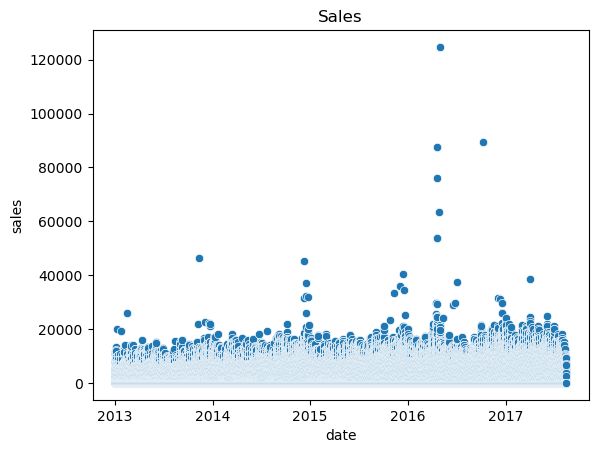

In [20]:
ax = sns.scatterplot(data=dados, x='date', y='sales')
ax.set_title('Sales')
plt.show()

In [21]:
for i in range(1,len(dados.store_nbr.unique())+1):
    val = dados[dados.store_nbr == i].sales.quantile(0.99)
    dados = dados.drop(dados[(dados.store_nbr==i) & (dados.sales > val)].index)

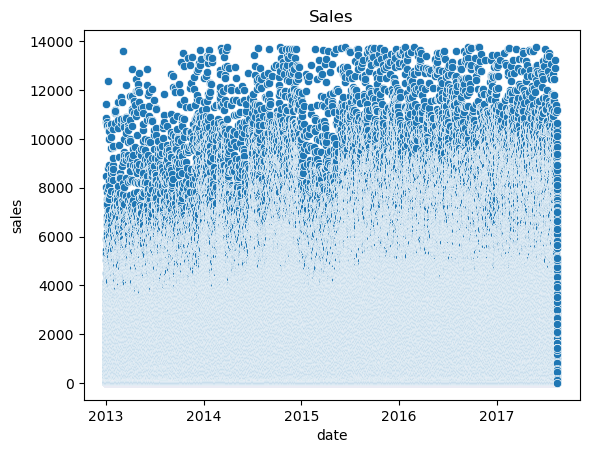

In [22]:
ax = sns.scatterplot(data=dados, x='date', y='sales')
ax.set_title('Sales')
plt.show()

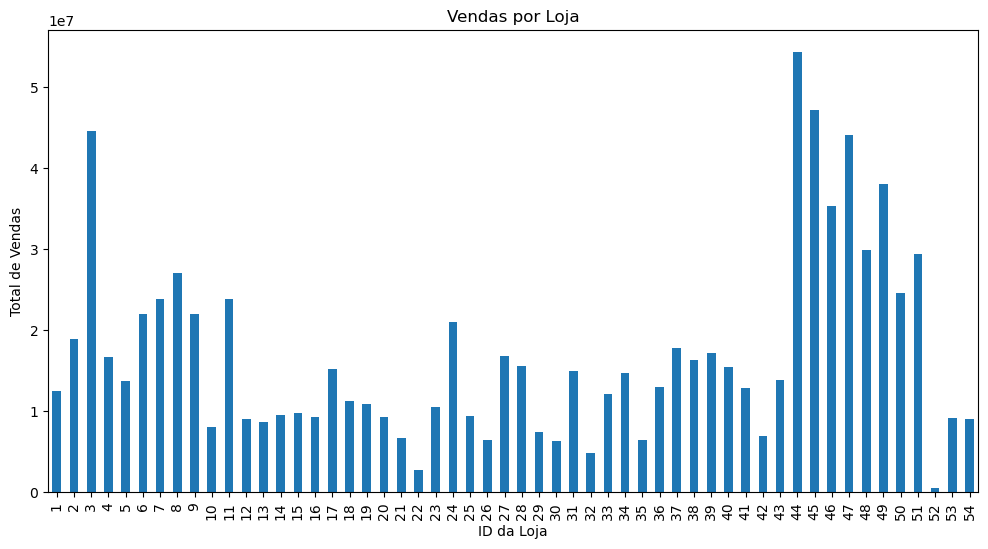

In [23]:
vendas_por_loja = dados.groupby('store_nbr')['sales'].sum()
plt.figure(figsize=(12, 6))
vendas_por_loja.plot(kind='bar')
plt.title('Vendas por Loja')
plt.xlabel('ID da Loja')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

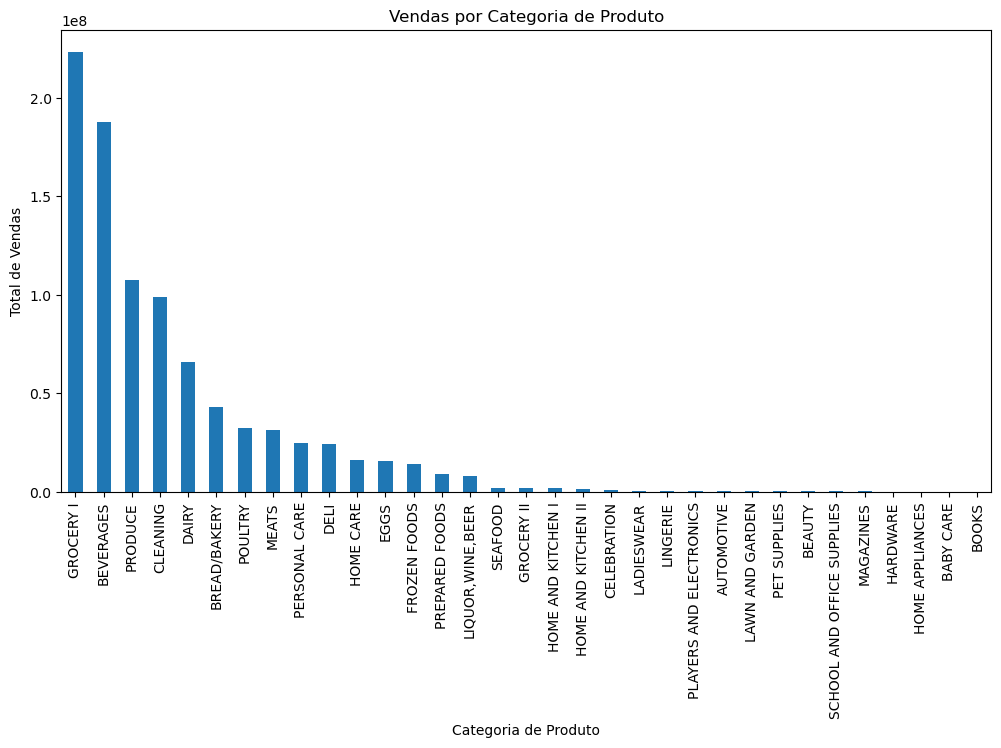

In [24]:
vendas_por_categoria = dados.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
vendas_por_categoria.plot(kind='bar')
plt.title('Vendas por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

In [25]:
def map_to_macrocategory2(category):
    #Função que a invés de agrupar por semelhantes, privilegia os grupos com maior quantidade de vendas
    if category in ['GROCERY I', 'BEVERAGES','PRODUCE' ,'CLEANING', 'DAIRY', 'BREAD/BAKERY']:
            return category
    else:
        return 'Auxiliar'

In [26]:
dados.set_index('date', inplace=True)

In [27]:
"""categorias = dados['family'].unique()
for categoria in categorias:
    plt.figure(figsize=(12, 6))
    vendas_categoria = dados[dados['family'] == categoria]['sales']
    vendas_categoria.groupby(vendas_categoria.index.year).sum().plot()
    plt.title(f'Tendência de Vendas Anuais para {categoria}')
    plt.xlabel('Ano')
    plt.ylabel('Vendas')
    plt.show()"""

"categorias = dados['family'].unique()\nfor categoria in categorias:\n    plt.figure(figsize=(12, 6))\n    vendas_categoria = dados[dados['family'] == categoria]['sales']\n    vendas_categoria.groupby(vendas_categoria.index.year).sum().plot()\n    plt.title(f'Tendência de Vendas Anuais para {categoria}')\n    plt.xlabel('Ano')\n    plt.ylabel('Vendas')\n    plt.show()"

In [28]:
#Percebe-se uma falta de vendas em certas categorias no início de 2013, verificaremos se no período existiam lojas ainda fechadas

In [29]:
"""lojas = dados['store_nbr'].unique()
for loja in lojas:
    plt.figure(figsize=(12, 6))
    vendas_loja = dados[dados['store_nbr'] == loja]['sales']
    vendas_loja.groupby(vendas_loja.index.year).sum().plot()
    plt.title(f'Tendência de Vendas Anuais para {loja}')
    plt.xlabel('Ano')
    plt.ylabel('Vendas')
    plt.show()"""

"lojas = dados['store_nbr'].unique()\nfor loja in lojas:\n    plt.figure(figsize=(12, 6))\n    vendas_loja = dados[dados['store_nbr'] == loja]['sales']\n    vendas_loja.groupby(vendas_loja.index.year).sum().plot()\n    plt.title(f'Tendência de Vendas Anuais para {loja}')\n    plt.xlabel('Ano')\n    plt.ylabel('Vendas')\n    plt.show()"

In [30]:
#ficou nítido que temos lojas ainda não abertas como 20, 21, 22, 29, 42, 52, 53

In [31]:
dados_agrupados = dados.groupby(['store_nbr', dados.index.date]).agg({'sales': 'sum'}).reset_index()
dados_agrupados.rename(columns={'level_1': 'date'}, inplace=True)

In [32]:
dados_agrupados.head()

,store_nbr,date,sales
0,1,2013-01-01,0.000000
1,1,2013-01-02,7417.148000
2,1,2013-01-03,5873.244001
3,1,2013-01-04,5919.879001
4,1,2013-01-05,6318.785010


In [33]:
store_ids = dados_agrupados['store_nbr'].unique()
for store_id in store_ids:
    primeiro_dia = primeiro_dia_com_vendas(store_id, dados_agrupados)
    if primeiro_dia is not None and primeiro_dia > pd.Timestamp('2013-01-02'):
        print(f'Loja {store_id}: Primeiro dia com vendas - {primeiro_dia}')

Loja 20: Primeiro dia com vendas - 2015-02-13 00:00:00
Loja 21: Primeiro dia com vendas - 2015-07-24 00:00:00
Loja 22: Primeiro dia com vendas - 2015-10-09 00:00:00
Loja 29: Primeiro dia com vendas - 2015-03-20 00:00:00
Loja 36: Primeiro dia com vendas - 2013-05-09 00:00:00
Loja 42: Primeiro dia com vendas - 2015-08-21 00:00:00
Loja 52: Primeiro dia com vendas - 2017-04-20 00:00:00
Loja 53: Primeiro dia com vendas - 2014-05-29 00:00:00


In [34]:
dados.reset_index(inplace=True)

In [35]:
print(dados.shape)
dados = dados[~((dados.store_nbr == 20) & (dados.date < "2015-02-13"))]
dados = dados[~((dados.store_nbr == 21) & (dados.date < "2015-07-24"))]
dados = dados[~((dados.store_nbr == 22) & (dados.date < "2015-10-09"))]
dados = dados[~((dados.store_nbr == 29) & (dados.date < "2015-03-20"))]
dados = dados[~((dados.store_nbr == 36) & (dados.date < "2013-05-09"))]
dados = dados[~((dados.store_nbr == 42) & (dados.date < "2015-08-21"))]
dados = dados[~((dados.store_nbr == 52) & (dados.date < "2017-04-20"))]
dados = dados[~((dados.store_nbr == 53) & (dados.date < "2014-05-29"))]
print(dados.shape)

(3023809, 7)
(2800069, 7)


In [36]:
categorias_nulas = dados.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
categorias_nulas = categorias_nulas[categorias_nulas.sales == 0]
categorias_nulas.head(100)

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [37]:
print(dados.shape)
outer_join = dados.merge(categorias_nulas.drop("sales",axis = 1), how = 'outer', indicator = True)
dados = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
dados.shape

(2800069, 7)


(2716926, 7)

In [38]:
dados.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.000000,1
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.140000,0
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.970000,0
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.120000,0
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.146667,1


In [39]:
dados = dados.merge(stores[['store_nbr', 'type', 'cluster']], on='store_nbr', how='left')
dados_val = dados_val.merge(stores[['store_nbr', 'type', 'cluster']], on='store_nbr', how='left')

In [40]:
dados.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.000000,1,D,13
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.140000,0,D,13
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.970000,0,D,13
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.120000,0,D,13
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.146667,1,D,13


In [41]:
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
holiday        0
type           0
cluster        0
dtype: int64


In [42]:
null_counts = dados_val.isnull().sum()
print(null_counts)

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dcoilwtico     0
holiday        0
type           0
cluster        0
dtype: int64


In [43]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
type                   object
cluster                 int64
dtype: object

In [44]:
dados_val.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dcoilwtico            float64
holiday                 int64
type                   object
cluster                 int64
dtype: object

In [45]:
dados['dia_da_semana'] = dados['date'].dt.dayofweek  
dados['dia_do_mes'] = dados['date'].dt.day      
dados['dia_do_ano'] = dados['date'].dt.dayofyear

dados_val['dia_da_semana'] = dados_val['date'].dt.dayofweek  
dados_val['dia_do_mes'] = dados_val['date'].dt.day      
dados_val['dia_do_ano'] = dados_val['date'].dt.dayofyear

In [46]:
dados.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,type,cluster,dia_da_semana,dia_do_mes,dia_do_ano
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.000000,1,D,13,1,1,1
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.140000,0,D,13,2,2,2
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.970000,0,D,13,3,3,3
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.120000,0,D,13,4,4,4
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.146667,1,D,13,5,5,5


In [47]:
dados_val.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,holiday,type,cluster,dia_da_semana,dia_do_mes,dia_do_ano
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,0,D,13,2,16,228
1,3000889,2017-08-16,1,BABY CARE,0,46.8,0,D,13,2,16,228
2,3000890,2017-08-16,1,BEAUTY,2,46.8,0,D,13,2,16,228
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,0,D,13,2,16,228
4,3000892,2017-08-16,1,BOOKS,0,46.8,0,D,13,2,16,228


In [48]:
dados["dia_de_pagamento"] = dados["date"].apply(payday)
dados_val["dia_de_pagamento"] = dados_val["date"].apply(payday)

In [49]:
dados.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,type,cluster,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.000000,1,D,13,1,1,1,0
1,2013-01-02,1,AUTOMOTIVE,2.0,0,93.140000,0,D,13,2,2,2,0
2,2013-01-03,1,AUTOMOTIVE,3.0,0,92.970000,0,D,13,3,3,3,0
3,2013-01-04,1,AUTOMOTIVE,3.0,0,93.120000,0,D,13,4,4,4,0
4,2013-01-05,1,AUTOMOTIVE,5.0,0,93.146667,1,D,13,5,5,5,0


In [50]:
dados_val.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,holiday,type,cluster,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,0,D,13,2,16,228,0
1,3000889,2017-08-16,1,BABY CARE,0,46.8,0,D,13,2,16,228,0
2,3000890,2017-08-16,1,BEAUTY,2,46.8,0,D,13,2,16,228,0
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,0,D,13,2,16,228,0
4,3000892,2017-08-16,1,BOOKS,0,46.8,0,D,13,2,16,228,0


In [51]:
dados_encoded = pd.get_dummies(dados, columns=['type'])
dados_val_encoded = pd.get_dummies(dados_val, columns=['type'])

In [52]:
dados_encoded.drop(columns=['date', 'type', 'index'], errors='ignore', inplace=True)
dados_val_encoded.drop(columns=['date', 'type', 'index'], errors='ignore', inplace=True)

In [53]:
dados_encoded.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,cluster,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento,type_A,type_B,type_C,type_D,type_E
0,1,AUTOMOTIVE,0.0,0,95.000000,1,13,1,1,1,0,False,False,False,True,False
1,1,AUTOMOTIVE,2.0,0,93.140000,0,13,2,2,2,0,False,False,False,True,False
2,1,AUTOMOTIVE,3.0,0,92.970000,0,13,3,3,3,0,False,False,False,True,False
3,1,AUTOMOTIVE,3.0,0,93.120000,0,13,4,4,4,0,False,False,False,True,False
4,1,AUTOMOTIVE,5.0,0,93.146667,1,13,5,5,5,0,False,False,False,True,False


In [54]:
dados_val_encoded.head()

,id,store_nbr,family,onpromotion,dcoilwtico,holiday,cluster,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento,type_A,type_B,type_C,type_D,type_E
0,3000888,1,AUTOMOTIVE,0,46.8,0,13,2,16,228,0,False,False,False,True,False
1,3000889,1,BABY CARE,0,46.8,0,13,2,16,228,0,False,False,False,True,False
2,3000890,1,BEAUTY,2,46.8,0,13,2,16,228,0,False,False,False,True,False
3,3000891,1,BEVERAGES,20,46.8,0,13,2,16,228,0,False,False,False,True,False
4,3000892,1,BOOKS,0,46.8,0,13,2,16,228,0,False,False,False,True,False


In [55]:
len(dados_encoded.columns)

16

In [56]:
dados_encoded.dtypes

store_nbr             int64
family               object
sales               float64
onpromotion           int64
dcoilwtico          float64
holiday               int64
cluster               int64
dia_da_semana         int32
dia_do_mes            int32
dia_do_ano            int32
dia_de_pagamento      int64
type_A                 bool
type_B                 bool
type_C                 bool
type_D                 bool
type_E                 bool
dtype: object

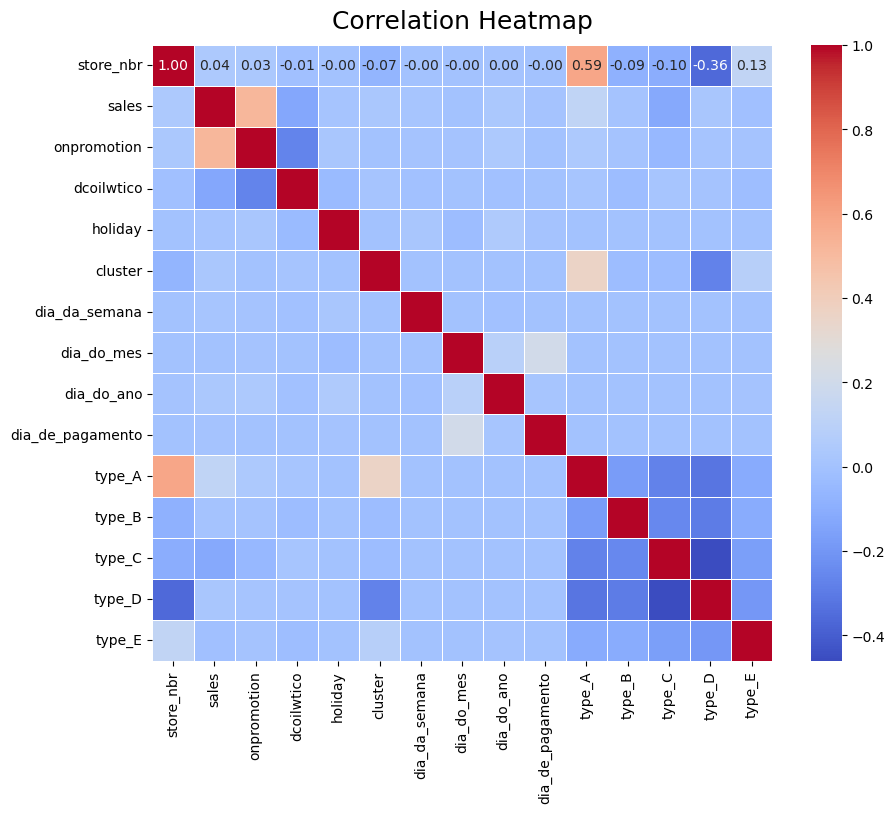

In [57]:
grafico = dados_encoded.drop(columns=['family'])
correlacao = grafico.corr(method='spearman')
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [58]:
label = dados_encoded['sales']
dados_encoded.drop(columns=['sales'], inplace=True)

In [59]:
X_treino, X_teste, y_treino, y_teste = train_test_split(dados_encoded, label, test_size=0.2, shuffle=False)

In [61]:
dataset_treino = X_treino.copy()
dataset_treino['sales'] = y_treino

In [62]:
modelo_composto = ProductRegressor(n_jobs=4)

In [63]:
modelo_composto.fit(dataset_treino)

In [64]:
y_pred = modelo_composto.predict(X_teste)

In [65]:
resul = RMSLE(y_pred, y_teste)
print(f"RMSLE for modelo_composto: {resul}")

RMSLE for modelo_composto: 0.846625846409251


In [66]:
y_pred_val = modelo_composto.predict(dados_val_encoded)

In [68]:
ids = dados_val_encoded['id']
dados_val_encoded.drop(columns=['id'], inplace=True)

In [69]:
y_pred_val_df = pd.DataFrame(y_pred_val, columns=['sales'])
df_validação = pd.concat([ids, y_pred_val_df], axis=1)
nome_arquivo = 'submission.csv'
df_validação.to_csv(nome_arquivo, index=False)

In [67]:
del modelo_composto